##  Chapter 11: Linear unsupervised learning

# 11.3  Feature scaling via ZCA sphereing

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
from mlrefined_libraries import basics_library as baslib
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'
from mlrefined_libraries import superlearn_library as superlearn
normalizers = superlearn.normalizers 

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.3.2 Feature scaling by Zero-phase Component Analysis (ZCA) sphereing

In [2]:
# load in dataset
datapath = 'mnist_test.csv'
data = np.loadtxt(datapath,delimiter = ',')

In [3]:
# divy up data into images and labels
images = data[:-1,:]
labels = data[-1,:]

<IPython.core.display.Javascript object>


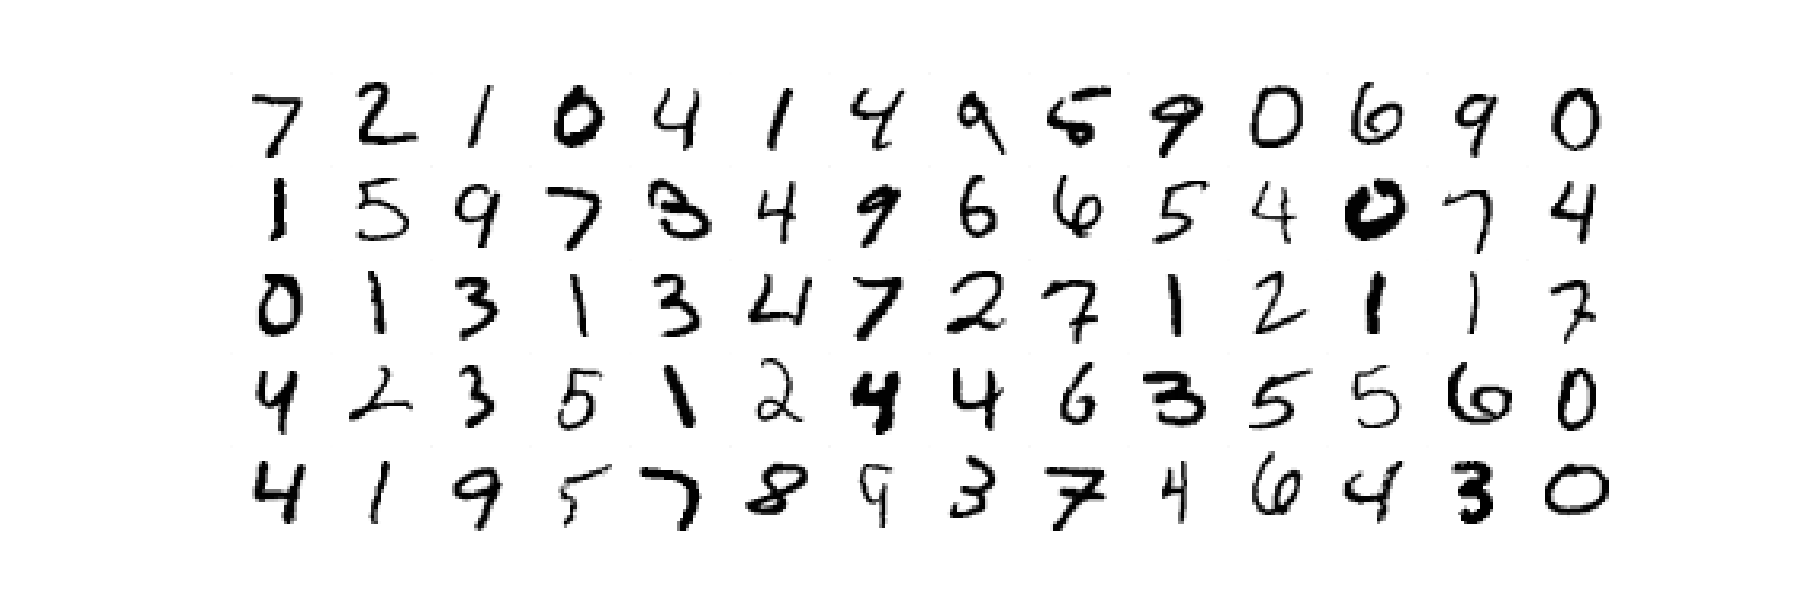

In [20]:
# plot a sample of the images
unsuplib.PCA_functionality.show_images(images)

Now we perform PCA-sphereing on this handwritten digit dataset, and plot the resulting PCA-sphered data.  Note: these are the same data points (transformed by the sphereing process, of course) we plotted above.

In [21]:
# compute eigendecomposition of data covariance matrix for PCA transformation
def PCA(x,**kwargs):
    # regularization parameter for numerical stability
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']

    # create the correlation matrix
    P = float(x.shape[1])
    Cov = 1/P*np.dot(x,x.T) + lam*np.eye(x.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    d,V = np.linalg.eigh(Cov)
    return d,V

# PCA-sphereing - use PCA to normalize input features
def PCA_sphereing(x,**kwargs):
    # Step 1: mean-center the data
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means

    # Step 2: compute pca transform on mean-centered data
    d,V = PCA(x_centered,**kwargs)

    # Step 3: divide off standard deviation of each (transformed) input, 
    # which are equal to the returned eigenvalues in 'd'.  
    stds = (d[:,np.newaxis])**(0.5)
    normalizer = lambda data: np.dot(V.T,data - x_means)/stds

    # create inverse normalizer
    inverse_normalizer = lambda data: np.dot(V,data*stds) + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

In [22]:
normalizer,inverse_normalizer = PCA_sphereing(images)

In [23]:
# PCA sphered data
pca_sphered_images = normalizer(images)

<IPython.core.display.Javascript object>


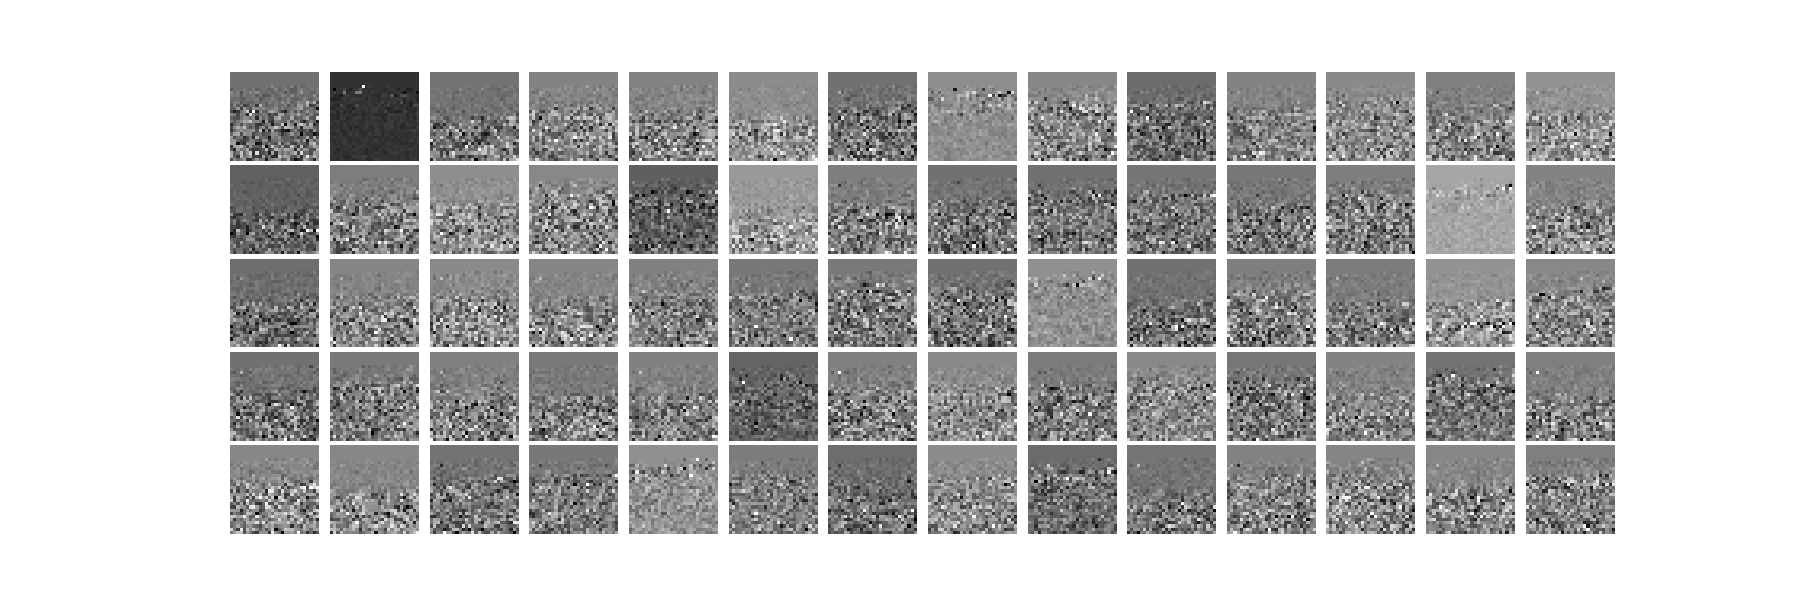

In [24]:
# plot PCA-sphered data
unsuplib.PCA_functionality.show_images(pca_sphered_images)

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/zca_sphereing.png' width="110%"  height="auto" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em> ZCA-sphereing illustrated. </em>  </figcaption> 
</figure>

In [25]:
def ZCA_sphere(x,**kwargs):
    '''
    A function for producing the ZCA sphereing on an input dataset X.  
    '''   
    # Step 1: mean-center the data
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means

    # Step 2: compute pca transform on mean-centered data
    d,V = PCA(x_centered,**kwargs)
    
    # Step 3: divide off standard deviation of each (transformed) input, 
    # which are equal to the returned eigenvalues in 'd'.  
    stds = (d[:,np.newaxis])**(0.5)
    pca_sphered_x = np.dot(V.T,x - x_means)/stds
        
    # Step 3: divide off standard deviation of each (transformed) input, 
    # which are equal to the returned eigenvalues in 'd'. 
    # Then rotate back to original orientation of space
    stds = (d[:,np.newaxis])**(0.5)
    normalizer = lambda data: np.dot(V,np.dot(V.T,data - x_means)/stds)
    
    return normalizer

With our ZCA-sphereing implementation written we can now transform the original centered dataset using it and examine the results.

In [28]:
# create ZCA normalizer
zca_normalizer = ZCA_sphere(images)

# ZCA-normalize input images
Z = zca_normalizer(images)

<IPython.core.display.Javascript object>


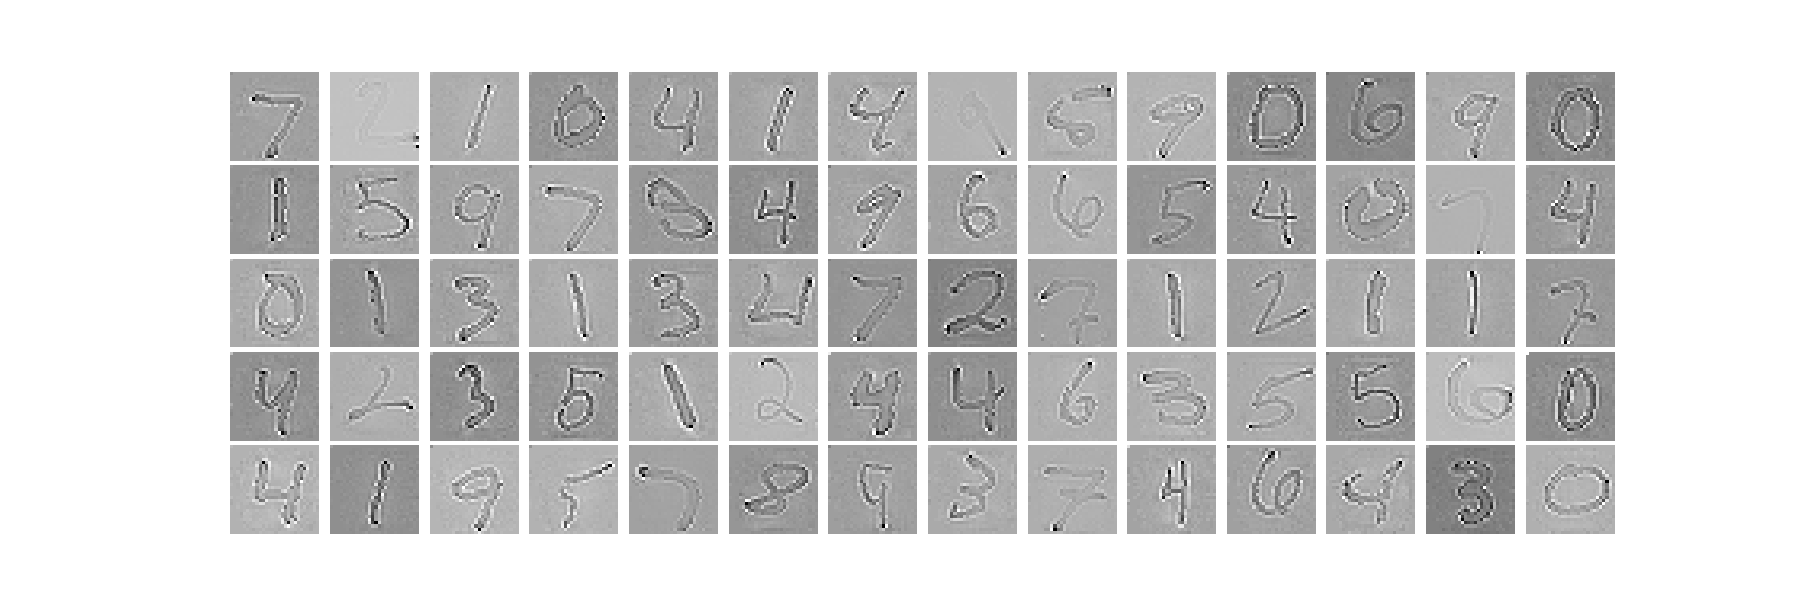

In [29]:
# plot PCA-sphered data
unsuplib.PCA_functionality.show_images(Z)

What a difference!  Indeed it was the rotation/reflection of PCA that destroyed most of the spatial correlation, since these ZCA-sphered images retain much of the spatial correlation present in their original versions.  Now we have the best of both worlds: a global normalization scheme (that will help speed up training) that retains the spatial structure of data leveraged e.g., by edge detectors and convolution operations.